In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
from selenium.webdriver.common.by import By

#명시적 대기
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd
import time

In [2]:
import math

# 1. 크롤링 및 데이터베이스 연동

In [3]:
main_url = 'https://www.tripadvisor.co.kr/Airline_Review-d12124804-Reviews-T-Way-Airlines'
driver = webdriver.Chrome("C:/2019_join_startup/remake_digital/chromedriver_win32/chromedriver.exe")
driver.get(main_url)

In [4]:
#한국어 리뷰 수
kor_count = driver.find_element_by_xpath('/html/body/div[2]/div/div/div[6]/div/div/div/div[2]/div[2]/div[2]/div/div[1]/div[1]/div[4]/ul/li[3]/label/span[2]').text
#kor_count = driver.find_element_by_css_selector('#component_1 > div > div.flights-airline-review-page-AirlineReviewPage__contentWrapper--1vfBd > div > div > div > div.ui_container.flights-airline-review-page-AirlineReviewPage__contentCard--3SVH- > div:nth-child(2) > div:nth-child(2) > div > div.location-review-review-list-parts-ReviewFilters__filters_wrap--y1t86 > div.ui_columns > div.ui_column.is-3-tablet.is-shown-at-tablet > ul > li:nth-child(3) > label > span.location-review-review-list-parts-LanguageFilter__paren_count--2vk3f').text
kor_count = int(kor_count[:-1].split('(')[1])
kor_review_page = math.ceil(kor_count/5)

In [5]:
kor_review_page

18

In [2]:
import pymysql

conn = pymysql.connect(host = 'localhost', user = 'test', password = '1234',
                       db = 'test', charset = 'utf8', port = 4306)

curs = conn.cursor()

In [49]:
class ReviewInfo:
    num = ''
    score = ''
    title = ''
    content = ''
    tour_y = ''
    tour_m = ''
    departure = ''
    arrival = ''
    continent = ''
    seat_class = ''
    
    def __init__(self,num,score,title,content,tour_y,tour_m,departure,arrival,continent,seat_class):
        self.num = num
        self.score = score
        self.title = title
        self.content = content
        self.tour_y = tour_y
        self.tour_m = tour_m
        self.departure = departure
        self.arrival = arrival
        self.continent = continent
        self.seat_class = seat_class
        
review_list = []    

In [7]:
insert_sql = """insert into twayreview (score,title,content,tour_y,tour_m,departure,arrival,continent,seat_class)
values (%s,%s,%s,%s,%s,%s,%s,%s,%s)"""

select_sql = """
SELECT LAST_INSERT_ID
"""

In [8]:
for page in range(1,kor_review_page+1):
    driver.find_elements_by_css_selector('.location-review-review-list-parts-ExpandableReview__cta--2mR2g')[0].click()
    try:
        #1페이지당 최대 5개 리뷰
        for j in range(0,5,1):
            #전체 데이터
            reviews =driver.find_elements_by_css_selector('.location-review-review-list-parts-SingleReview__mainCol--1hApa')

            #평가점수
            score_str = reviews[j].find_element_by_css_selector('.ui_bubble_rating').get_attribute('class')
            score = score_str.split('ui_bubble_rating bubble_')[1]

            #리뷰 제목
            title = reviews[j].find_element_by_css_selector('.location-review-review-list-parts-ReviewTitle__reviewTitle--2GO9Z').text

            #리뷰 내용
            content = reviews[j].find_element_by_css_selector('.location-review-review-list-parts-ExpandableReview__reviewText--gOmRC').text
            content

            #여행 날짜(년도,월) #예외처리
            try:  
                date = reviews[j].find_element_by_css_selector(".location-review-review-list-parts-EventDate__event_date--1epHa").text.split(' ')
                tour_y = date[2][:-1]
                tour_m = date[3][:-1]
            except Exception as e1:
                tour_y = 'Nan'
                tour_m = 'Nan'
                
            #출발지 여행지 좌석
            info = reviews[j].find_element_by_css_selector('.location-review-review-list-parts-RatingLine__labelsContainer--rSajH').text.split('\n')
            #출발지
            departure = info[0].split(' - ')[0]
            #도착지
            arrival = info[0].split(' - ')[1]
            #대륙
            continent = info[1]
            #좌석
            seat_class = info[2]
            print('score:%s\n제목:%s\n내용:%s\n여행날짜(년):%s\n여행날짜(월):%s\n출발지:%s\n도착지:%s\n대륙:%s\n좌석등급:%s\n' %(score,title,content,tour_y,tour_m,departure,arrival,continent,seat_class))
            print('='*100)
            
            #데이터베이스 연동            
            curs.execute(insert_sql, (score,title,content,tour_y,tour_m,departure,arrival,continent,seat_class))
            conn.commit()
            
            #curs.execute(select_sql)

       
        if (page != kor_review_page+1):
            driver.find_element_by_xpath('//a[@class="ui_button nav next primary "]').click() #다음페이지 클릭
            time.sleep(2)
        
        print('%s 페이지 이동' %(page+1))
      
    except Exception as e:
        print('이동 오류',e)

score:50
제목:이 시국에 일본여행이 없기는 없네요
내용:안녕하세요
9월에 일본 나고야출장을 가게되어 티웨이항공이 시간도 맞아서 저비용항공사를 이용했는데 한국인 여행자들이 거의 전무하여 비행기가 텅텅비어 운항하게 되었습니다
손가락으로 꼽을수 있을만큼 비행기 이용객이 적어서 나고야행 비행기가 없어지는 것이 아닐까 걱정될 정도입니다
여행날짜(년):2019
여행날짜(월):9
출발지:서울
도착지:나고야
대륙:북아시아
좌석등급:이코노미

score:50
제목:무난한 비행
내용:자주 잉요하는 항공사로 노선이 적절절해서 이용하고 있음. 항공사 직원들의 서비스가 매우 만족스러움. 자격대비 만족도 높음.
여행날짜(년):2019
여행날짜(월):10
출발지:대구
도착지:세부
대륙:동남아시아
좌석등급:이코노미

score:10
제목:뱅기 놓친다더니 ㅡ.ㅡ
내용:리뷰 읽으면서 남의 일로만 생각했는데 김.포. 공.항. 출발 40분전에 도착했는데 카운터에 직원 흔적조차 없네. 도대체 언제 카운터를 닫는 거요?!! 도심이랑 가까워서 금액도 꽤 지불하고 예약한 편도인데 놓치고 인천공항 가게 될듯. 뎅장.
여행날짜(년):2019
여행날짜(월):10
출발지:서울
도착지:타이페이
대륙:북아시아
좌석등급:이코노미

score:30
제목:좌석이 좁지만, 승무원이 친절하여 무난함.
내용:저가 항공이다보니, 좌석이 좁다.
아이들과 여행이라면 국적기 이용을 권하고 싶다.
성인들끼리라면 가성비면에서, 짧은 거리면 괜찮은편이다.
여행날짜(년):2018
여행날짜(월):11
출발지:아가나
도착지:서울
대륙:국외
좌석등급:이코노미

score:30
제목:승무원은 매우 친절. 그러나 너무 좁음
내용:항공에 큰 기대는 없었지만. 좌석이 앞뒤로 너무 좁은데 정말 아무 생각없이 뒤로 확 제끼시는 분들이 너무 많았어요.. 전 다리도 펼수없었고.. 키가 180이 넘어가시는 남자분들은 마치 의자에 딱 붙어 가는.. 우리 남편도 190이다보니 거구에.. 무릎이 그냥 앞좌석에 닿는데 자꾸 뒤로 밀어서 무릎이 멍들었어요.ㅠㅠ

score:40
제목:저렴한 가격!
내용:저렴한가격이니까 탑니다!! 좌석의 넓이는 좁아요! 저는 다리 짧으니까 괜찮은게 다리긴 사람들은 힘들꺼 같아요!직원들은 친절해요.
여행날짜(년):2019
여행날짜(월):2
출발지:서울
도착지:나고야
대륙:북아시아
좌석등급:이코노미

score:10
제목:모니터 없음
내용:할말이 없습니다. 너무 열악하여서 그렇기도 하지만 탑승게이트 역시 지하철로 버스로 이동하여서 여간 불편하기 이를데 없네요.저가 항공사를 이용할수 밖에 없어서 이용하였지만 이번 출장길은 내 생애 최악이라 생각되어 다시는 저가 항공편 이용하지 않을 각오 입니다.
여행날짜(년):2019
여행날짜(월):1
출발지:서울
도착지:호치민시
대륙:동남아시아
좌석등급:이코노미

6 페이지 이동
score:50
제목:저렴한 가격에 이용할 수 있는 티웨이항공.
내용:좌석이 약간 좁긴 하지만, 국내노선이나 해외단거리노선(일본) 갈 때에는 불편함을 느낄 시간도 없이 금방 착륙해서 불편함 없이 탑승할 수 있습니다. 물 한잔도 안주는 저가항공사도 있다는데, 승객 모두에게는 아니지만 원하는 승객에게 물도 주십니다. 승무원분들도 정말 친절하시고, 저렴한 가격에 이용가능해서 좋았습니다.
여행날짜(년):2019
여행날짜(월):1
출발지:무안
도착지:오이타
대륙:북아시아
좌석등급:이코노미

score:40
제목:값싸게 이용가능한 비행
내용:왕복비행 19만원에 베트남을 다녀왔어요.
기내 baggages 도 10kg까지 넉넉해서 따로 수화물 붙일 필요없음.
다른 저가항공처럼 좁은 좌석, 비싼 기내식, 밤늦은 출발과 도착은 감수해야함.
부산 pm10시 출발해서 하노이 am1시에 도착
하노이 am2시 출발 부산am8시 도착함
여행날짜(년):2019
여행날짜(월):1
출발지:부산
도착지:하노이
대륙:동남아시아
좌석등급:이코노미

score:20
제목:화장실 청소는 승객이 해야하나?
내용:5일간의 비지니스 여행~ 구마모토까지 직항이 티웨이 항공밖에 없어서 뭐 그냥 잠깐 타는거니 타고 가자는 마음이었으

score:50
제목:티웨이 항공 세부행 이용
내용:티웨이 항공으로 대구 출발 세부행 이용해봤습니다. 돈 추가해서 최전방 유료 프리미엄 좌석을 구매해서 이용해봤는데, 일반 좌석에 비해서 여유공간이 상대적으로 편합니다.
부담 크게 안되신다면 티웨이 이용시 유료 지정 죄석 구매도 나쁘지 않네요.
여행날짜(년):2018
여행날짜(월):5
출발지:대구
도착지:세부
대륙:동남아시아
좌석등급:이코노미

score:30
제목:저가항공으로 무난합니다.
내용:저가항공사 다운 항공입니다. 좌석이 좁아서 장시간 비행으로는 허리가 아플 것 같고, 3시간 내외인 국가를 다니기 적절한 것 같습니다. 승무원들은 친절하며, 기내식은 별도로 없었습니다. 장거리보다는 근거리에 적합한 항공사입니다.
여행날짜(년):2017
여행날짜(월):7
출발지:서울
도착지:제주
대륙:국내
좌석등급:이코노미

score:50
제목:일본은 진에어 대만은 티웨이!!!
내용:저가항공은 역시 싼맛인듯 ㅎ
여행삼매경애 빠진 요즘 항공료를 아껴야 여행지에서 두배로 즐길수 있다는것!!!
서비스나 시설은 비슷하다면 포인트적립을 배제할정도로 싼가격에 표가 나왔다면 망설임없이 겟잇!!!
여기저기 다녀본결과 대만은 티웨이 일번은 진에어가 갑인듯~
그리고 언제나 내짐은 소중하기에 위탁수하물에는 조심표시 달아주는 센스~

근데 이스타랑 공동운항하지만 이스타는 비싸고 티웨이는 싼이유가 뭘까?!?!
여행날짜(년):2018
여행날짜(월):5
출발지:청주
도착지:타이페이
대륙:북아시아
좌석등급:이코노미

11 페이지 이동
score:10
제목:탑승구가 제2터미널에 있었는데 제대로 안내도 안해주고 결국 비행기 놓쳤어요
내용:발권해서 표받을때 탑승권주면서 탑승구간이 제2터미널인거 얘기도 안해주고 1터미널에서 시간보내고 있다고 전화화서 열라게 뛰어갔는데 15분늣어서 비행기 떠났어요.. 늣은 잘못도 있었지만.. 저흰 몰랐어요.. 탑승터미널이 또 있는줄은.. 바로 다음편 티웨이 같은 지역 도착행있었는데 못태워준다면서 좌석이 만석인것도 아닌데.. 못

score:40
제목:저렴하게 타기 좋아요
내용:연착으로 악명높았는데 거의 정시 출발했구요. 새벽 비행기가 너무 추워서 힘들긴했어요. 좌석은 저가항공에 비해 좀 넓은 편이었구요. 나름 가격대비 괜찮아서 나중에 또 특가뜨면 이용하려구요
여행날짜(년):2017
여행날짜(월):9
출발지:서울
도착지:호치민시
대륙:동남아시아
좌석등급:이코노미

score:30
제목:저렴한 LCC....
내용:저렴한 항공료로 다른 모든 것을 상쇄시키는 비행. LCC에 대한항공이나 아시아나급의 서비스를 바라는 것은 현대차를 타면서 벤츠나 BMW의 성능을 바라는 것과 같음. 가성비는 매우 좋음.
여행날짜(년):2017
여행날짜(월):1
출발지:대구
도착지:세부
대륙:동남아시아
좌석등급:이코노미

16 페이지 이동
score:40
제목:실속파 여행
내용:음료서비스 없어도 제주도보다 비행기표가 쌌다. 좌석이 좀 낡은 듯 했으나 짧은 비행시간이라 괜찮았다. 올때 기념품을 많이 샀다면 일행과 나누어 짐을 싸는 게 좋겠다. 수하물 초과비용을 덜 내려면!
여행날짜(년):2017
여행날짜(월):7
출발지:서울
도착지:구마모토
대륙:북아시아
좌석등급:이코노미

score:30
제목:연착으로 여행 일정 지연
내용:17년 1월 21일 토요일 대구발 홍콩행 비행기였으나 2시간 반 가량 지연 됨.
여행 계획에 차질이 발생하였음.
도착 즉시 심포니오브라이트를 보려고 했으나 비행기 지연으로 인해 야경을 볼 수 없었음.
티켓은 특가를 활용하여 매우 저렴하게 예약하여 가격부분에서는 만족 함.
좌석은 적당히 불편하였으나 캐릭터가 귀여움...
저가답게 물 한잔도 안주니 미리미리 준비하여 갈 것.
여행날짜(년):2017
여행날짜(월):1
출발지:대구
도착지:홍콩
대륙:아시아
좌석등급:이코노미

score:30
제목:티웨이는 안타고 싶어요
내용:클럽메드과 항공권패키지상품을 이용해서 여행을 다녀왔는데 토요일 출발은 티웨이라.
일반석밖에 없었고, 지인이 맨앞자리는 미리 구입가능하다고해서 출발2일전에 전화로 결제해서 4명좌석 왕

# 2. 데이터베이스 데이터 불러오기

In [3]:
import pandas as pd

In [4]:
data = pd.read_sql("select * from twayreview",conn)

In [5]:
data

,num,score,title,content,tour_y,tour_m,departure,arrival,continent,seat_class
0,1,50,이 시국에 일본여행이 없기는 없네요,안녕하세요\n9월에 일본 나고야출장을 가게되어 티웨이항공이 시간도 맞아서 저비용항공...,2019,9,서울,나고야,북아시아,이코노미
1,2,50,무난한 비행,자주 잉요하는 항공사로 노선이 적절절해서 이용하고 있음. 항공사 직원들의 서비스가 ...,2019,10,대구,세부,동남아시아,이코노미
2,3,10,뱅기 놓친다더니 ㅡ.ㅡ,리뷰 읽으면서 남의 일로만 생각했는데 김.포. 공.항. 출발 40분전에 도착했는데 ...,2019,10,서울,타이페이,북아시아,이코노미
3,4,30,"좌석이 좁지만, 승무원이 친절하여 무난함.","저가 항공이다보니, 좌석이 좁다.\n아이들과 여행이라면 국적기 이용을 권하고 싶다....",2018,11,아가나,서울,국외,이코노미
4,5,30,승무원은 매우 친절. 그러나 너무 좁음,항공에 큰 기대는 없었지만. 좌석이 앞뒤로 너무 좁은데 정말 아무 생각없이 뒤로 확...,2019,9,서울,하이커우,북아시아,이코노미
5,6,30,좌석좁은 것빼고 무난. 하지만 하이난(싼야SYX)공항은 힘드네요,좌석이 좁은것 말곤 무난합니다만.\n\n항공사보다는 하이난(싼야SYX)공항에서 수속...,2019,9,산야,서울,북아시아,이코노미
6,7,30,무난하였으나 좌석은 조금 좁네요,좌석은 좁은 편이네요. 좌석을 가장 뒤로 눕히면 거의 움직일 틈이 없는 정도입니다....,2019,9,서울,산야,북아시아,이코노미
7,8,30,좌석간격이 너무 좁아요,좁아도 너무 좁아요. 2시간 정도면 단거리 구간이기는 하지만 좌석간격이 너무 좁아서...,2019,9,서울,타이페이,북아시아,이코노미
8,9,20,저가항공사가 그렇죠뭐..,너무 좁아요. 키가 180 넘는 분들은 안쓰럽.. 자리가 좁다보니 뒤에서 자꾸 부딪...,2019,7,대구,하노이,동남아시아,이코노미
9,10,20,정말... 최악이었다.,지방이라 직항이 티웨이 밖에 없어 선택할 수 없었다.\n부산까지 가서 타기에는 가고...,2019,7,대구,방콕,동남아시아,이코노미


# 3. 데이터 분석 (텍스트 마이닝)

In [16]:
#data['score'] = data['score'].str.slice(stop=1) #전처리

In [17]:
#data['score'] = data['score'].astype(int) # 점수 부분 정수형으로 변환

In [26]:
data.to_csv('tway_review_kor.csv', encoding='cp949')

In [29]:
data = pd.read_csv('tway_review_kor.csv',encoding='cp949')
del data['Unnamed: 0']
data.head()

,num,score,title,content,tour_y,tour_m,departure,arrival,continent,seat_class
0,1,5,이 시국에 일본여행이 없기는 없네요,안녕하세요\n9월에 일본 나고야출장을 가게되어 티웨이항공이 시간도 맞아서 저비용항공...,2019,9,서울,나고야,북아시아,이코노미
1,2,5,무난한 비행,자주 잉요하는 항공사로 노선이 적절절해서 이용하고 있음. 항공사 직원들의 서비스가 ...,2019,10,대구,세부,동남아시아,이코노미
2,3,1,뱅기 놓친다더니 ㅡ.ㅡ,리뷰 읽으면서 남의 일로만 생각했는데 김.포. 공.항. 출발 40분전에 도착했는데 ...,2019,10,서울,타이페이,북아시아,이코노미
3,4,3,"좌석이 좁지만, 승무원이 친절하여 무난함.","저가 항공이다보니, 좌석이 좁다.\n아이들과 여행이라면 국적기 이용을 권하고 싶다....",2018,11,아가나,서울,국외,이코노미
4,5,3,승무원은 매우 친절. 그러나 너무 좁음,항공에 큰 기대는 없었지만. 좌석이 앞뒤로 너무 좁은데 정말 아무 생각없이 뒤로 확...,2019,9,서울,하이커우,북아시아,이코노미


1.이코노미만을 이용

In [30]:
data['seat_class'].value_counts() #저가항공사는 역시 이코노미만을 이용한다!

이코노미    90
Name: seat_class, dtype: int64

2. 만족도 비율

In [57]:
data['score'].value_counts() # 수 비율 파생변수 만들기

4    33
3    26
5    16
2     9
1     6
Name: score, dtype: int64

In [46]:
import seaborn as sns

C:\education\bigdata\python\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\education\bigdata\python\anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


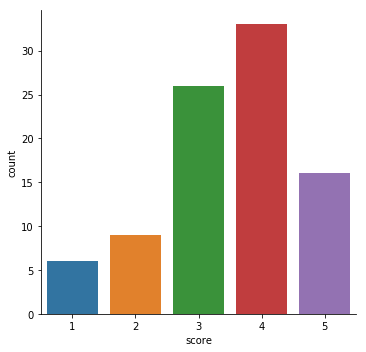

In [60]:
g = sns.factorplot('score',data = data, kind = 'count', size = 5)
g.set_xticklabels(rotation=0)
g.set_xlabels()

In [32]:
data['score'].value_counts()/len(data)*100 # 수 비율 파생변수 만들기

4    36.666667
3    28.888889
5    17.777778
2    10.000000
1     6.666667
Name: score, dtype: float64

3. 여행 날짜

In [33]:
data['tour_y'].value_counts()

2017    34
2018    27
2019    25
2016     3
Nan      1
Name: tour_y, dtype: int64

C:\education\bigdata\python\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\education\bigdata\python\anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


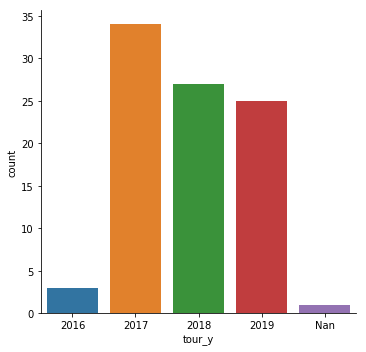

In [62]:
g = sns.factorplot('tour_y',data = data, kind = 'count', size = 5)
g.set_xticklabels(rotation=0)
g.set_xlabels()

4. 여행 간 월
==> 7-9월 (휴가철) 프로모션 / 그 외 월 프로모션 진행

In [34]:
data['tour_m'].value_counts()

7      12
9      12
1      10
8      10
11      9
6       8
12      6
2       6
3       5
5       5
4       3
10      3
Nan     1
Name: tour_m, dtype: int64

C:\education\bigdata\python\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\education\bigdata\python\anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


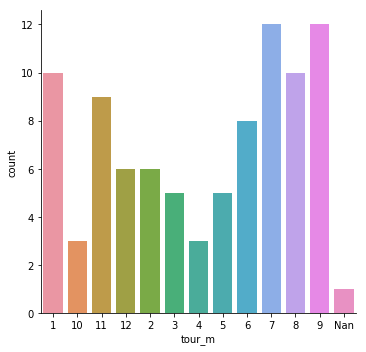

In [63]:
g = sns.factorplot('tour_m',data = data, kind = 'count', size = 5)
g.set_xticklabels(rotation=0)
g.set_xlabels()

In [35]:
data['departure'].value_counts()

서울         57
대구         14
부산          7
비엔티안        2
청주          1
호치민시        1
아가나         1
오사카         1
무안          1
산야          1
다낭          1
광주          1
제주          1
블라디보스토크     1
Name: departure, dtype: int64

In [64]:
data['arrival'].value_counts()

서울         9
다낭         8
하노이        6
제주         6
방콕         6
오사카        5
타이페이       5
후쿠오카       5
사가         4
치토세        4
아가나        3
세부         3
오키나와       3
도쿄         3
나고야        2
산야         2
오이타        2
호치민시       2
사이판        2
구마모토       2
타이중        2
하이커우       1
코타키나발루     1
홍콩         1
푸켓         1
마카오        1
Omitama    1
Name: arrival, dtype: int64

In [67]:
import matplotlib #한글깨짐현상 방지
matplotlib.rcParams['font.family'] = 'Malgun Gothic'   # '맑은 고딕'으로 설정 
matplotlib.rcParams['axes.unicode_minus']

True

C:\education\bigdata\python\anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\education\bigdata\python\anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


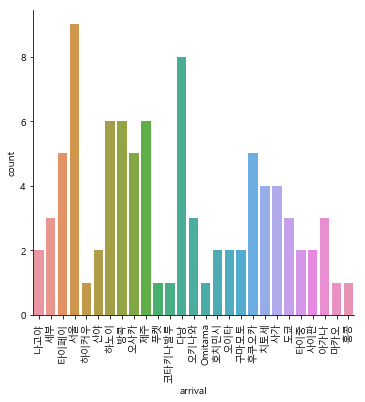

In [68]:
g = sns.factorplot('arrival',data = data, kind = 'count', size = 5)
g.set_xticklabels(rotation=90)
g.set_xlabels()

5. 북아시아 / 동남아시아 목적지가 제일 많음

In [37]:
data['continent'].value_counts()

북아시아     47
동남아시아    27
국내        7
국외        7
아시아       2
Name: continent, dtype: int64

In [38]:
data['continent'].value_counts()/len(data)*100

북아시아     52.222222
동남아시아    30.000000
국내        7.777778
국외        7.777778
아시아       2.222222
Name: continent, dtype: float64

# 4. 4점-5점(좋음-아주 좋음) 평가자 data 분석

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 10 columns):
num           90 non-null int64
score         90 non-null int64
title         90 non-null object
content       90 non-null object
tour_y        90 non-null object
tour_m        90 non-null object
departure     90 non-null object
arrival       90 non-null object
continent     90 non-null object
seat_class    90 non-null object
dtypes: int64(2), object(8)
memory usage: 7.1+ KB


In [40]:
data.head()

,num,score,title,content,tour_y,tour_m,departure,arrival,continent,seat_class
0,1,5,이 시국에 일본여행이 없기는 없네요,안녕하세요\n9월에 일본 나고야출장을 가게되어 티웨이항공이 시간도 맞아서 저비용항공...,2019,9,서울,나고야,북아시아,이코노미
1,2,5,무난한 비행,자주 잉요하는 항공사로 노선이 적절절해서 이용하고 있음. 항공사 직원들의 서비스가 ...,2019,10,대구,세부,동남아시아,이코노미
2,3,1,뱅기 놓친다더니 ㅡ.ㅡ,리뷰 읽으면서 남의 일로만 생각했는데 김.포. 공.항. 출발 40분전에 도착했는데 ...,2019,10,서울,타이페이,북아시아,이코노미
3,4,3,"좌석이 좁지만, 승무원이 친절하여 무난함.","저가 항공이다보니, 좌석이 좁다.\n아이들과 여행이라면 국적기 이용을 권하고 싶다....",2018,11,아가나,서울,국외,이코노미
4,5,3,승무원은 매우 친절. 그러나 너무 좁음,항공에 큰 기대는 없었지만. 좌석이 앞뒤로 너무 좁은데 정말 아무 생각없이 뒤로 확...,2019,9,서울,하이커우,북아시아,이코노미


In [41]:
good_review = data[data.score>=4]
good_review

,num,score,title,content,tour_y,tour_m,departure,arrival,continent,seat_class
0,1,5,이 시국에 일본여행이 없기는 없네요,안녕하세요\n9월에 일본 나고야출장을 가게되어 티웨이항공이 시간도 맞아서 저비용항공...,2019,9,서울,나고야,북아시아,이코노미
1,2,5,무난한 비행,자주 잉요하는 항공사로 노선이 적절절해서 이용하고 있음. 항공사 직원들의 서비스가 ...,2019,10,대구,세부,동남아시아,이코노미
14,15,4,좌석간 폭은 굉장히 좁았지만 분실물 서비스는 최고 (인천-코타키나발루),짧지않은 비행시간동안 아이 동반으로 가기에는 이코노미 좌석이 굉장히 좁게 느껴졌습니...,2018,8,서울,코타키나발루,동남아시아,이코노미
16,17,4,저렴한 항공가격,가격이 저렴하니 많은걸 바라면 안되겠죵??\n기내식을 신청하지 않아 기내식에 대해 ...,2019,6,부산,다낭,동남아시아,이코노미
17,18,5,처음 간 베트남여행,날씨는 매우덥고 습도도 높았지만 가성비 좋은 여행였네요\n베트남 음식도 제입에 딱 ...,2019,6,부산,하노이,동남아시아,이코노미
19,20,4,생각보다 좋아요,2시간 30분정도 비행을 했지만 비교적 안전하고 편한 여행 이었어요.. 하지만 기내...,2019,5,서울,오키나와,북아시아,이코노미
20,21,4,가성비를 따진다면 우선 고려할 수 있는 항공사,하노이를 방문하면서 싼 표를 찾던 중 김해에서 왕복하는 티웨이 항공편을 발견하고 이...,2019,3,부산,하노이,동남아시아,이코노미
23,24,4,저렴한 가격!,저렴한가격이니까 탑니다!! 좌석의 넓이는 좁아요! 저는 다리 짧으니까 괜찮은게 다리...,2019,2,서울,나고야,북아시아,이코노미
25,26,5,저렴한 가격에 이용할 수 있는 티웨이항공.,"좌석이 약간 좁긴 하지만, 국내노선이나 해외단거리노선(일본) 갈 때에는 불편함을 느...",2019,1,무안,오이타,북아시아,이코노미
26,27,4,값싸게 이용가능한 비행,왕복비행 19만원에 베트남을 다녀왔어요.\n기내 baggages 도 10kg까지 넉...,2019,1,부산,하노이,동남아시아,이코노미


In [22]:
import nltk
from konlpy.tag import Twitter
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/gulim.ttc").get_name()
rc('font',family = font_name)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

t = Twitter()

C:\education\bigdata\python\anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
C:\education\bigdata\python\anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [42]:
import nltk
from konlpy.tag import Okt; t = Okt()

In [43]:
good_review_content = good_review['content']
good_review_content

0     안녕하세요\n9월에 일본 나고야출장을 가게되어 티웨이항공이 시간도 맞아서 저비용항공...
1     자주 잉요하는 항공사로 노선이 적절절해서 이용하고 있음. 항공사 직원들의 서비스가 ...
14    짧지않은 비행시간동안 아이 동반으로 가기에는 이코노미 좌석이 굉장히 좁게 느껴졌습니...
16    가격이 저렴하니 많은걸 바라면 안되겠죵??\n기내식을 신청하지 않아 기내식에 대해 ...
17    날씨는 매우덥고 습도도 높았지만 가성비 좋은 여행였네요\n베트남 음식도 제입에 딱 ...
19    2시간 30분정도 비행을 했지만 비교적 안전하고 편한 여행 이었어요.. 하지만 기내...
20    하노이를 방문하면서 싼 표를 찾던 중 김해에서 왕복하는 티웨이 항공편을 발견하고 이...
23    저렴한가격이니까 탑니다!! 좌석의 넓이는 좁아요! 저는 다리 짧으니까 괜찮은게 다리...
25    좌석이 약간 좁긴 하지만, 국내노선이나 해외단거리노선(일본) 갈 때에는 불편함을 느...
26    왕복비행 19만원에 베트남을 다녀왔어요.\n기내 baggages 도 10kg까지 넉...
28    약 4시간 가량 걸리는 저가항공 치고는 오래 걸리는 비행이였지만\n큰 불편함 없이 ...
29    통상의 경우 대한항공이나 아시아나는 국제편의 경우 기내식과 음료를 무상제공하지만\n...
30    저렴하게 잘 이용했습니다.\n지연은 없었고 1시간 내외로 짧은 비행시간이기에 충분히...
31    새벽 비행이 싫어서 티웨이 낮비행기로 움직였습니다. 저가항공이라 기내식은 추가 주문...
32    저가항공사. 기내식도 사전에 주문하면 그럴듯하다. 단거리 노선이라고 하기 조금 멀 ...
34    비행기가 조금 작아서 기류에 영향을 받는 것 빼고는, 기내 음식과 서비스 모두 좋았...
35    특가 찬스로 저렴하게 갔다왔네요 티웨이는 특가항공권 사도 수화물 수수료가 저렴해서 ...
36    발권 직전 만석이었기에 무료로 비상구석을 받을 수 있게 도와준 카운터 직원에

In [69]:
len(good_review_content)

49

In [ ]:
content_text = ''

for each_line in  

In [71]:
tokens_ko = t.morphs(good_review_content)
tokens_ko

TypeError: No matching overloads found for kr.lucypark.okt.OktInterface.tokenize(Series,java.lang.Boolean,java.lang.Boolean), options are:
	public java.util.List kr.lucypark.okt.OktInterface.tokenize(java.lang.String,java.lang.Boolean,java.lang.Boolean)

	at JPMethod::findOverload(native\common\jp_method.cpp:242)
	at JPMethod::findOverload(native\common\jp_method.cpp:245)
	at JPMethod::invoke(native\common\jp_method.cpp:253)
	at PyJPMethod::__call__(native\python\pyjp_method.cpp:142)


In [72]:
data['title']

0                         이 시국에 일본여행이 없기는 없네요
1                                      무난한 비행
2                                뱅기 놓친다더니 ㅡ.ㅡ
3                     좌석이 좁지만, 승무원이 친절하여 무난함.
4                       승무원은 매우 친절. 그러나 너무 좁음
5         좌석좁은 것빼고 무난. 하지만 하이난(싼야SYX)공항은 힘드네요
6                           무난하였으나 좌석은 조금 좁네요
7                                좌석간격이 너무 좁아요
8                               저가항공사가 그렇죠뭐..
9                                정말... 최악이었다.
10                    외할머니 집 왔는데 지연으로 환승 놓쳤어요
11                         항공기 지연에 아무런 안내도 없음
12                     한국의 대표적인 LCC 항공사 중에 하나
13                                      별로...
14    좌석간 폭은 굉장히 좁았지만 분실물 서비스는 최고 (인천-코타키나발루)
15                                  티웨이는 티웨이다
16                                   저렴한 항공가격
17                                 처음 간 베트남여행
18                                    최악의 서비스
19                                   생각보다 좋아요
20                  가성비를 따진다면 우선 고려할 수 있는 항공사
21                                

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 10 columns):
num           90 non-null int64
score         90 non-null int64
title         90 non-null object
content       90 non-null object
tour_y        90 non-null object
tour_m        90 non-null object
departure     90 non-null object
arrival       90 non-null object
continent     90 non-null object
seat_class    90 non-null object
dtypes: int64(2), object(8)
memory usage: 7.1+ KB


In [86]:
#object to string
data['title'] = data['title'].astype(str) 

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 10 columns):
num           90 non-null int64
score         90 non-null int64
title         90 non-null object
content       90 non-null object
tour_y        90 non-null object
tour_m        90 non-null object
departure     90 non-null object
arrival       90 non-null object
continent     90 non-null object
seat_class    90 non-null object
dtypes: int64(2), object(8)
memory usage: 7.1+ KB


In [90]:
wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',
                     relative_scaling=0.2,
                     background_color='white').generate_from_frequencies(dict(data['title']))

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

ValueError: could not convert string to float: '훌륭한 저가 항공사'

In [93]:
review_title = data['title']
review_title

0                         이 시국에 일본여행이 없기는 없네요
1                                      무난한 비행
2                                뱅기 놓친다더니 ㅡ.ㅡ
3                     좌석이 좁지만, 승무원이 친절하여 무난함.
4                       승무원은 매우 친절. 그러나 너무 좁음
5         좌석좁은 것빼고 무난. 하지만 하이난(싼야SYX)공항은 힘드네요
6                           무난하였으나 좌석은 조금 좁네요
7                                좌석간격이 너무 좁아요
8                               저가항공사가 그렇죠뭐..
9                                정말... 최악이었다.
10                    외할머니 집 왔는데 지연으로 환승 놓쳤어요
11                         항공기 지연에 아무런 안내도 없음
12                     한국의 대표적인 LCC 항공사 중에 하나
13                                      별로...
14    좌석간 폭은 굉장히 좁았지만 분실물 서비스는 최고 (인천-코타키나발루)
15                                  티웨이는 티웨이다
16                                   저렴한 항공가격
17                                 처음 간 베트남여행
18                                    최악의 서비스
19                                   생각보다 좋아요
20                  가성비를 따진다면 우선 고려할 수 있는 항공사
21                                

In [95]:
import nltk
from konlpy.tag import Twitter; t = Twitter()

C:\education\bigdata\python\anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [96]:
title_text = ''

for each_line in review_title:
    title_text = title_text + each_line +'\n'

In [97]:
tokens_ko = t.morphs(title_text)
tokens_ko

['이',
 '시국',
 '에',
 '일본여행',
 '이',
 '없기는',
 '없네요',
 '\n',
 '무난',
 '한',
 '비행',
 '\n',
 '뱅기',
 '놓친다더니',
 'ㅡ',
 '.',
 'ㅡ',
 '\n',
 '좌석',
 '이',
 '좁지만',
 ',',
 '승무원',
 '이',
 '친절하여',
 '무난',
 '함',
 '.',
 '\n',
 '승무원',
 '은',
 '매우',
 '친절',
 '.',
 '그러나',
 '너무',
 '좁음',
 '\n',
 '좌석',
 '좁은',
 '것',
 '빼고',
 '무난',
 '.',
 '하지만',
 '하이난',
 '(',
 '싼야',
 'SYX',
 ')',
 '공항',
 '은',
 '힘드네요',
 '\n',
 '무난',
 '하였으나',
 '좌석',
 '은',
 '조금',
 '좁네요',
 '\n',
 '좌석',
 '간격',
 '이',
 '너무',
 '좁아요',
 '\n',
 '저가항공사',
 '가',
 '그렇죠',
 '뭐',
 '..',
 '\n',
 '정말',
 '...',
 '최악',
 '이었다',
 '.',
 '\n',
 '외할머니',
 '집',
 '왔는데',
 '지연',
 '으로',
 '환승',
 '놓쳤어요',
 '\n',
 '항공기',
 '지연',
 '에',
 '아무런',
 '안내',
 '도',
 '없음',
 '\n',
 '한국',
 '의',
 '대표',
 '적',
 '인',
 'LCC',
 '항공사',
 '중',
 '에',
 '하나',
 '\n',
 '별로',
 '...',
 '\n',
 '좌석',
 '간',
 '폭',
 '은',
 '굉장히',
 '좁았지만',
 '분실물',
 '서비스',
 '는',
 '최고',
 '(',
 '인천',
 '-',
 '코타키나발루',
 ')',
 '\n',
 '티웨이',
 '는',
 '티웨이',
 '다',
 '\n',
 '저렴한',
 '항공',
 '가격',
 '\n',
 '처음',
 '간',
 '베트남',
 '여행',
 '\n',
 '최악',
 '의',
 '서비스

In [98]:
ko = nltk.Text(tokens_ko)
ko.vocab().most_common(100)

[('\n', 90),
 ('가격', 21),
 ('.', 14),
 ('에', 13),
 ('저렴한', 12),
 ('항공', 11),
 ('이', 10),
 ('은', 9),
 ('티웨이', 9),
 ('저가', 9),
 ('이용', 9),
 ('좌석', 7),
 ('으로', 7),
 ('서비스', 7),
 ('여행', 7),
 ('무난', 6),
 ('비행', 6),
 ('적', 5),
 ('는', 5),
 ('한', 4),
 ('너무', 4),
 ('...', 4),
 ('의', 4),
 ('LCC', 4),
 ('항공사', 4),
 ('좋아요', 4),
 ('!', 4),
 ('대비', 4),
 ('지연', 3),
 ('인', 3),
 ('중', 3),
 ('최고', 3),
 ('대구', 3),
 ('~', 3),
 ('잘', 3),
 ('비행기', 3),
 ('저렴하게', 3),
 ('탑승', 3),
 ('만큼의', 3),
 ('만족', 3),
 ('이지만', 3),
 ('ㅡ', 2),
 (',', 2),
 ('승무원', 2),
 ('좁음', 2),
 ('좁은', 2),
 ('하지만', 2),
 ('(', 2),
 (')', 2),
 ('공항', 2),
 ('저가항공사', 2),
 ('가', 2),
 ('..', 2),
 ('최악', 2),
 ('놓쳤어요', 2),
 ('항공기', 2),
 ('안내', 2),
 ('도', 2),
 ('없음', 2),
 ('간', 2),
 ('-', 2),
 ('다', 2),
 ('보다', 2),
 ('비', 2),
 ('할', 2),
 ('수', 2),
 ('있는', 2),
 ('단거리', 2),
 ('맞는', 2),
 ('ㅜㅜ', 2),
 ('행', 2),
 ('왕복', 2),
 ('제', 2),
 ('만족스러운', 2),
 ('추천', 2),
 ('연착', 2),
 ('좋은', 2),
 ('시국', 1),
 ('일본여행', 1),
 ('없기는', 1),
 ('없네요', 1),
 ('뱅기', 1),
 ('놓친다더니

In [109]:
stop_words = ['.','에','이','은','으로','는','...','도', '함','의','인','(',')','가','-','다','ㅜㅜ','의','~','ㅡ',',','!']
tokens_kor = [each_word for each_word in tokens_ko 
             if each_word not in stop_words]

ko = nltk.Text(tokens_kor)
ko.vocab().most_common(100)

[('\n', 90),
 ('가격', 21),
 ('저렴한', 12),
 ('항공', 11),
 ('티웨이', 9),
 ('저가', 9),
 ('이용', 9),
 ('좌석', 7),
 ('서비스', 7),
 ('여행', 7),
 ('무난', 6),
 ('비행', 6),
 ('적', 5),
 ('한', 4),
 ('너무', 4),
 ('LCC', 4),
 ('항공사', 4),
 ('좋아요', 4),
 ('대비', 4),
 ('지연', 3),
 ('중', 3),
 ('최고', 3),
 ('대구', 3),
 ('잘', 3),
 ('비행기', 3),
 ('저렴하게', 3),
 ('탑승', 3),
 ('만큼의', 3),
 ('만족', 3),
 ('이지만', 3),
 ('승무원', 2),
 ('좁음', 2),
 ('좁은', 2),
 ('하지만', 2),
 ('공항', 2),
 ('저가항공사', 2),
 ('..', 2),
 ('최악', 2),
 ('놓쳤어요', 2),
 ('항공기', 2),
 ('안내', 2),
 ('없음', 2),
 ('간', 2),
 ('보다', 2),
 ('비', 2),
 ('할', 2),
 ('수', 2),
 ('있는', 2),
 ('단거리', 2),
 ('맞는', 2),
 ('행', 2),
 ('왕복', 2),
 ('제', 2),
 ('만족스러운', 2),
 ('추천', 2),
 ('연착', 2),
 ('좋은', 2),
 ('시국', 1),
 ('일본여행', 1),
 ('없기는', 1),
 ('없네요', 1),
 ('뱅기', 1),
 ('놓친다더니', 1),
 ('좁지만', 1),
 ('친절하여', 1),
 ('매우', 1),
 ('친절', 1),
 ('그러나', 1),
 ('것', 1),
 ('빼고', 1),
 ('하이난', 1),
 ('싼야', 1),
 ('SYX', 1),
 ('힘드네요', 1),
 ('하였으나', 1),
 ('조금', 1),
 ('좁네요', 1),
 ('간격', 1),
 ('좁아요', 1),
 ('그렇죠', 1),
 ('뭐

In [111]:
words = ko.vocab()
words

FreqDist({'\n': 90, '가격': 21, '저렴한': 12, '항공': 11, '티웨이': 9, '저가': 9, '이용': 9, '좌석': 7, '서비스': 7, '여행': 7, ...})

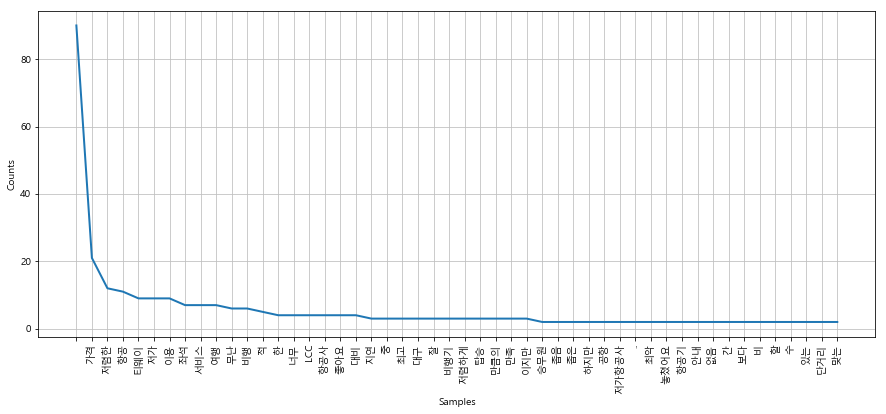

In [110]:
import graphviz
from sklearn.tree import export_graphviz
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

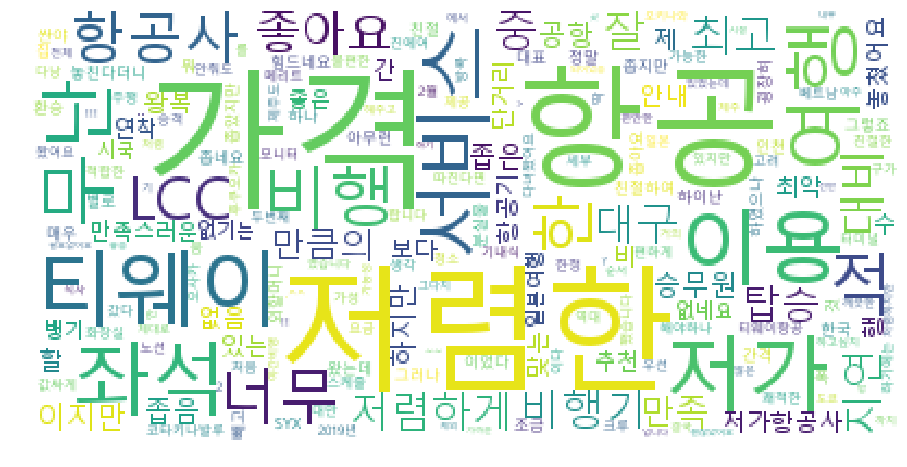

In [112]:
wordcloud = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf',
                     relative_scaling=0.2,
                     background_color='white').generate_from_frequencies(words)

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [116]:
review_content = data['content']
review_content

0     안녕하세요\n9월에 일본 나고야출장을 가게되어 티웨이항공이 시간도 맞아서 저비용항공...
1     자주 잉요하는 항공사로 노선이 적절절해서 이용하고 있음. 항공사 직원들의 서비스가 ...
2     리뷰 읽으면서 남의 일로만 생각했는데 김.포. 공.항. 출발 40분전에 도착했는데 ...
3     저가 항공이다보니, 좌석이 좁다.\n아이들과 여행이라면 국적기 이용을 권하고 싶다....
4     항공에 큰 기대는 없었지만. 좌석이 앞뒤로 너무 좁은데 정말 아무 생각없이 뒤로 확...
5     좌석이 좁은것 말곤 무난합니다만.\n\n항공사보다는 하이난(싼야SYX)공항에서 수속...
6     좌석은 좁은 편이네요. 좌석을 가장 뒤로 눕히면 거의 움직일 틈이 없는 정도입니다....
7     좁아도 너무 좁아요. 2시간 정도면 단거리 구간이기는 하지만 좌석간격이 너무 좁아서...
8     너무 좁아요. 키가 180 넘는 분들은 안쓰럽.. 자리가 좁다보니 뒤에서 자꾸 부딪...
9     지방이라 직항이 티웨이 밖에 없어 선택할 수 없었다.\n부산까지 가서 타기에는 가고...
10    2시간 가까이 지연되는 바람에\n간사이 공항에 갔던 시점에서 니가타행 비행기가\n이...
11    처음 한국에서 출국하는 과정도 정신없더니 귀국하기는 더 힘들었습니다. 공항에 조금 ...
12    06:20분 김포발 비행기를 이용했다.\n저가항공사 치고 보통은 다 가는것 같았다....
13    7시20분 비행기 tw103편행 비상구좌석 사전구매해서 탑승했습니다.\n사실 비상구...
14    짧지않은 비행시간동안 아이 동반으로 가기에는 이코노미 좌석이 굉장히 좁게 느껴졌습니...
15    옛날 태국여행갔을때 티웨이를 탔었기에 매우 불안했었습니다\n하지만 비수기인지라 자리...
16    가격이 저렴하니 많은걸 바라면 안되겠죵??\n기내식을 신청하지 않아 기내식에 대해 ...
17    날씨는 매우덥고 습도도 높았지만 가성비 좋은 여행였네요\n베트남 음식도 제입

In [117]:
content_text = ''

for each_line in review_content:
    content_text = content_text + each_line +'\n'

In [118]:
tokens_ko = t.morphs(content_text)
tokens_ko

['안녕하세요',
 '\n',
 '9월',
 '에',
 '일본',
 '나고야',
 '출장',
 '을',
 '가게',
 '되어',
 '티웨이항공',
 '이',
 '시간',
 '도',
 '맞아서',
 '저비용항공사',
 '를',
 '이용',
 '했는데',
 '한국인',
 '여행자',
 '들',
 '이',
 '거의',
 '전무하여',
 '비행기',
 '가',
 '텅텅',
 '비어',
 '운항',
 '하게',
 '되었습니다',
 '\n',
 '손가락',
 '으로',
 '꼽을수',
 '있을만큼',
 '비행기',
 '이용',
 '객',
 '이',
 '적어서',
 '나고야',
 '행',
 '비행기',
 '가',
 '없어지는',
 '것',
 '이',
 '아닐까',
 '걱정',
 '될',
 '정도',
 '입니다',
 '\n',
 '자주',
 '잉요하',
 '는',
 '항공사',
 '로',
 '노선',
 '이',
 '적절',
 '절',
 '해서',
 '이용',
 '하고',
 '있음',
 '.',
 '항공사',
 '직원',
 '들',
 '의',
 '서비스',
 '가',
 '매우',
 '만족스러',
 '움',
 '.',
 '자격',
 '대비',
 '만족도',
 '높음',
 '.',
 '\n',
 '리뷰',
 '읽으면서',
 '남',
 '의',
 '일로',
 '만',
 '생각',
 '했는데',
 '김',
 '.',
 '포',
 '.',
 '공',
 '.',
 '항',
 '.',
 '출발',
 '40분',
 '전에',
 '도착',
 '했는데',
 '카운터',
 '에',
 '직원',
 '흔적',
 '조차',
 '없네',
 '.',
 '도대체',
 '언제',
 '카운터',
 '를',
 '닫는',
 '거',
 '요',
 '?!!',
 '도심',
 '이랑',
 '가까워서',
 '금액',
 '도',
 '꽤',
 '지불',
 '하고',
 '예약',
 '한',
 '편도',
 '인데',
 '놓치고',
 '인천공항',
 '가게',
 '될듯',
 '.',
 '뎅',
 '장',
 '.',
 '\n',
 

In [119]:
ko = nltk.Text(tokens_ko)
ko.vocab().most_common(100)

[('.', 248),
 ('\n', 247),
 ('이', 152),
 ('에', 100),
 ('은', 84),
 ('도', 83),
 ('을', 75),
 (',', 64),
 ('가', 63),
 ('는', 53),
 ('이용', 49),
 ('들', 49),
 ('좌석', 47),
 ('항공', 40),
 ('로', 39),
 ('를', 38),
 ('가격', 38),
 ('비행기', 36),
 ('..', 35),
 ('에서', 35),
 ('수', 35),
 ('것', 34),
 ('서비스', 32),
 ('저가', 32),
 ('비행', 31),
 ('티웨이', 29),
 ('의', 28),
 ('으로', 27),
 ('할', 27),
 ('항공사', 25),
 ('때', 25),
 ('한', 23),
 ('여행', 23),
 ('너무', 23),
 ('하고', 20),
 ('출발', 20),
 ('...', 20),
 ('지연', 20),
 ('공항', 19),
 ('승무원', 19),
 ('기내식', 19),
 ('시간', 18),
 ('인', 18),
 ('해서', 16),
 ('과', 16),
 ('적', 16),
 ('생각', 15),
 ('기', 15),
 ('다른', 15),
 ('도착', 14),
 ('탑승', 14),
 ('기내', 14),
 ('잘', 14),
 ('저렴한', 14),
 ('있는', 14),
 ('정도', 13),
 ('입니다', 13),
 ('매우', 13),
 ('만', 13),
 ('앞', 13),
 ('\n\n', 13),
 ('자리', 13),
 ('더', 13),
 ('조금', 13),
 ('저가항공사', 13),
 ('연착', 13),
 ('정말', 12),
 ('없이', 12),
 ('하지만', 12),
 ('물', 12),
 ('좋은', 12),
 ('행', 11),
 ('아이', 11),
 ('하는', 11),
 ('나', 11),
 ('못', 11),
 ('좀', 11),
 ('있습니다', 1